In [1]:
import pylab
import pandas
import numpy as np
import sklearn
import sklearn.multiclass
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.base import LinearClassifierMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [37]:
def grad_descent(X, y, w, v, param, C, is_l1):
    grad = param * np.sign(v) if is_l1 else param * 2.0 * w
    f1 = np.exp(-y * np.dot(w + v, X.T))
    res = np.repeat((C * -y * (f1 / (1.0 + f1))).reshape(X.shape[0], 1), X.shape[1], axis=1) * X
    return grad + res.sum(axis=0)

In [52]:
def optimizator(X, y, lambd, mu, C, max_iter, eps, alpha):
    k = 0
    w = np.zeros(X.shape[1])
    v = np.zeros(X.shape[1])
    
    while True:
        vec = np.add(w, v)
        
        # making optimization in w and v
        v -= alpha * grad_descent(X, y, w, v, mu, C, True)
        w -= alpha * grad_descent(X, y, w, v, lambd, C, False)
                
        k += 1
        if k >= max_iter or np.linalg.norm(np.add(w,v) - vec, ord=2) < eps:
            break

    return max_iter, w, v

class L1L2(BaseEstimator, LinearClassifierMixin):

    def __init__(self, lambd=1., mu=1., C=1., max_iter=1000, eps=0.0001, alpha=0.001, fit_intercept=True):
        self.lambd = lambd
        self.mu = mu
        self.C = C
        self.max_iter = max_iter
        self.eps = eps
        self.alpha = alpha
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        self.classes_, y = np.unique(y, return_inverse=True)
        y = 2. * y - 1
        if self.fit_intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))
        self.n_iter_, self.w_, self.v_ = optimizator(X, y, self.lambd, self.mu, self.C, 
                                                     self.max_iter, self.alpha, self.eps)
        self.coef_ = np.add(self.w_, self.v_).reshape((1, X.shape[1]))
        self.intercept_ = 0.0
        if self.fit_intercept:
            self.intercept_ = self.coef_[:,-1]
            self.coef_ = self.coef_[:,:-1]
        return self
    
    def predict_proba(self, X):
        return super(BaseL1L2, self)._predict_proba_lr(X)
    
    def get_params(self, deep=True):
        return {'lambd': self.lambd, 
                'mu': self.mu, 
                'C': self.C, 
                'max_iter': self.max_iter, 
                'eps': self.eps, 
                'alpha': self.alpha, 
                'fit_intercept': self.fit_intercept}

Basic test for multi class clasification

100 loops, best of 3: 3.3 ms per loop
1000 loops, best of 3: 463 µs per loop


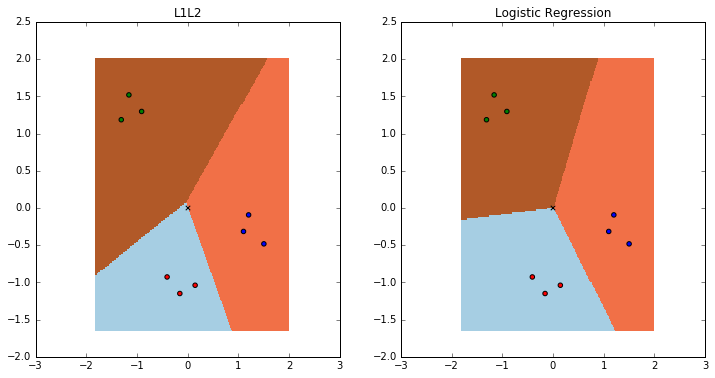

In [53]:
X = np.zeros((9, 2))
X[:,0] = [0, 1.1 , 0.5, 3, 3.8, 3.2, -1, -1.5, -1.8]
X[:,1] = [-1, -1.2, -1.4, 0.1, -0.2, 0.5, 3, 3.4, 2.8]
X = sklearn.preprocessing.scale(X)

y = [1,1,1,2,2,2,3,3,3]

%matplotlib inline

pylab.figure(figsize=(12,6))
for i, (title, reg) in enumerate([('L1L2', OneVsRestClassifier(L1L2(fit_intercept=True, lambd=0.5, max_iter=5000))), 
                                  ('Logistic Regression', LogisticRegression(fit_intercept=True))
                                  ]):    
    %timeit reg.fit(X, y)

    pylab.subplot(1, 2, i+1)
    
    h = .02  # step size in the mesh

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    pylab.figure(1, figsize=(4, 3))
    pylab.pcolormesh(xx, yy, Z, cmap=pylab.cm.Paired)

    pylab.scatter(X[:,0], X[:,1], c=[{1:'r', 2:'b', 3:'g'}[y_] for y_ in y])
    pylab.scatter(0,0, marker='x', c='k')
    
    pylab.title(title)

Test with reduced (2 attributes, all classes) digits data set.

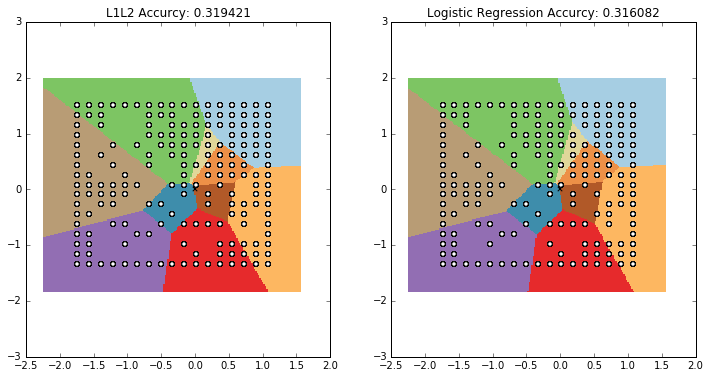

In [55]:
import sklearn.datasets
from sklearn.metrics import accuracy_score

data = sklearn.datasets.load_digits()
X = sklearn.preprocessing.scale(data['data'][:,[18,50]])
y = data['target']

pylab.figure(figsize=(12,6))
for i, (title, reg) in enumerate([('L1L2', OneVsRestClassifier(L1L2(fit_intercept=True))), 
                                  ('Logistic Regression', LogisticRegression(fit_intercept=True))
                                  ]):
    reg.fit(X, y)
    
    pylab.subplot(1, 2, i+1)
    
    h = .02  # step size in the mesh

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    pylab.figure(1, figsize=(4, 3))
    pylab.pcolormesh(xx, yy, Z, cmap=pylab.cm.Paired)
    
    for y_ in np.unique(y):
        c = pylab.cm.Paired(y_ / float(len(np.unique(y))))
        y_ = y == reg.predict(X)
        pylab.scatter(X[:,0][y_], X[:,1][y_], c='w')
    pylab.scatter(0,0, marker='x', c='k')
    
    pylab.title(title + (' Accurcy: %g' % accuracy_score(y, reg.predict(X))))


Test with reduced with complete digits data set.

In [56]:
from sklearn.grid_search import GridSearchCV
import sklearn.datasets
from sklearn.cross_validation import StratifiedKFold

data = sklearn.datasets.load_digits()
X = sklearn.preprocessing.scale(data['data'])
y = data['target']

gs = GridSearchCV(OneVsRestClassifier(L1L2()), {'estimator__C':[1, 0.5]}, scoring='accuracy', cv=StratifiedKFold(y, n_folds=3), n_jobs=-1)
gs.fit(X, y)
print 'Accuracy L1+L2:', gs.best_score_

gs = GridSearchCV(LogisticRegression(), {}, scoring='accuracy', cv=StratifiedKFold(y, n_folds=3), n_jobs=-1)
gs.fit(X, y)
gs.best_score_
print 'Accuracy Logistic Regression:', gs.best_score_

Accuracy L1+L2: 0.927100723428
Accuracy Logistic Regression: 0.92264885921


Example Grid Search

In [ ]:
clf = OneVsRestClassifier(estimator=L1L2())
param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100], 
              'estimator__lambd':[0.01, 0.1, 1, 10, 100], 
                  'estimator__mu':[0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(clf, 
                  param_grid, 
                  scoring=scoring, 
                  cv=3,
                  n_jobs=-1)